---
title: "Scaling numerical features safely"
format:
    revealjs:
        slide-number: true
        toc: true
        code-fold: false
        code-tools: true

---

Now that we can apply selections to any column we want thanks to `ApplyToCols` and
the selectors, it is time to scale numerical features safely.

## Numerical features with outliers

When dealing with numerical features that contain outliers (including infinite values), standard scaling methods can be problematic. Outliers can dramatically affect the centering and scaling of the entire dataset, causing the scaled inliers to be compressed into a narrow range.

Consider this example:

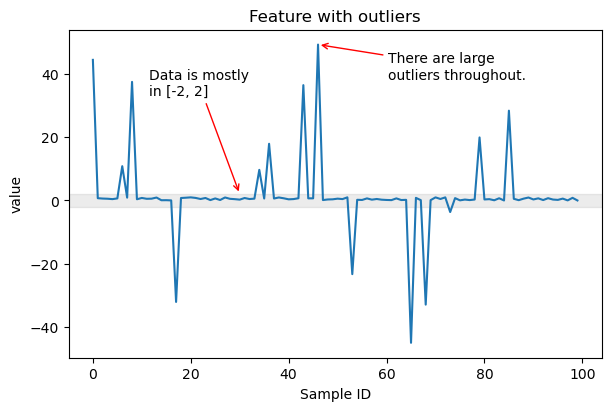

In [1]:
from helpers import (
    generate_data_with_outliers,
    plot_feature_with_outliers
)

values = generate_data_with_outliers()

plot_feature_with_outliers(values)

In this case, most of the values are in the range `[-2, 2]`, but there are some 
large outliers in the range `[-40, 40]` that can cause issues when the feature 
needs to be scaled. 


### Regular scalers and their limitations

The **StandardScaler** computes mean and standard deviation across all values.
With outliers present, these statistics become unreliable, and the scaling factor
can become too small, squashing inlier values.

The **RobustScaler** uses quantiles (typically the 25th and 75th percentiles)
instead of mean/std, which makes it more resistant to outliers. However, it
doesn't bound the output values, so extreme outliers can still have very large
scaled values.

### SquashingScaler: A robust solution

The `SquashingScaler` combines robust centering with smooth clipping to handle
outliers effectively. It works in two stages:

### Stage 1: Robust Scaling
- Centers the median to zero
- Scales using quantile-based statistics (by default, the interquartile range)
- For columns where quantiles are equal, uses a custom MinMaxScaler
- For columns with constant values, fills with zeros

### Stage 2: Soft Clipping
- Applies a smooth squashing function:
$x_{\text{out}} = \frac{z}{\sqrt{1 + (z/B)^2}}$
- Constrains all values to the range
$[-\texttt{max\_absolute\_value}, \texttt{max\_absolute\_value}]$ (default: 3)
- Maps infinite values to the corresponding boundaries
- Preserves NaN values unchanged

### Key advantages of `SquashingScaler`
The `SquashingScaler` has various advantages over traditional scalers: 

- It is **Outlier-resistant**: Outliers don't affect inlier scaling, unlike the
`StandardScaler`.
- It has **Bounded output**: All values stay in a predictable range, ideal for 
neural networks and linear models.
- It **Handles edge cases**: The scaler works with infinite values and constant 
columns.
- It **Preserves missing data**: NaN values are kept unchanged. 

A disadvantage of the `SquashingScaler` is that it is**Non-invertible**: 
The soft clipping function is smooth but cannot be exactly inverted. 

## Comparison with other scalers

When compared on data with outliers:
- **StandardScaler** compresses inliers due to large scaling factors
- **RobustScaler** preserves relative scales but allows extreme outlier values
- **SquashingScaler** keeps inliers in a reasonable range while smoothly bounding all values

If we plot the impact of each scaler on the result, this is what we can see: 

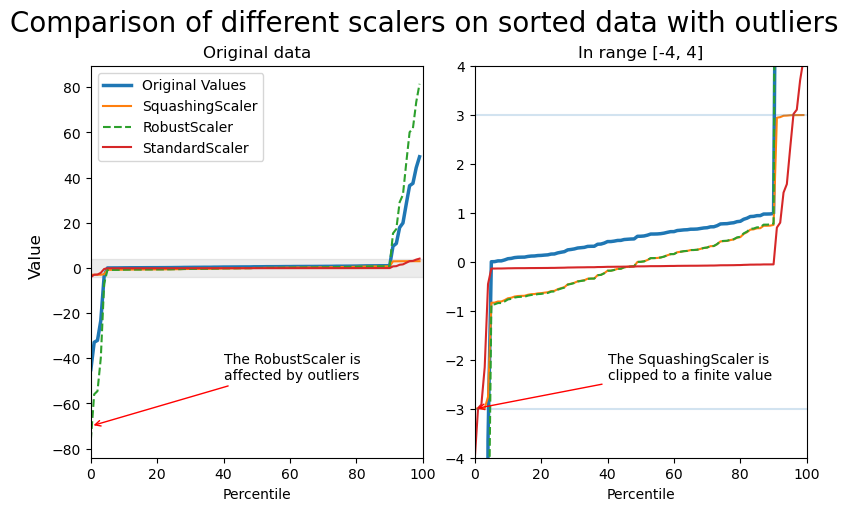

In [2]:
from helpers import scale_feature_and_plot
scale_feature_and_plot(values)